In [22]:
from ase.io import read, write
from ase.visualize import view

atoms = read('TiN.cif')
view(atoms) 

<Popen: returncode: None args: ['c:\\Users\\ameer\\miniforge3\\envs\\ase\\py...>

In [19]:
atoms = read('ZrN.poscar')
view(atoms)
write('ZrN.cif', atoms)

Reading data from 'crystal_e_convergence.csv'...
Data successfully parsed.

Convergence plot saved to ecutwfc_convergence_subplots_plot.png


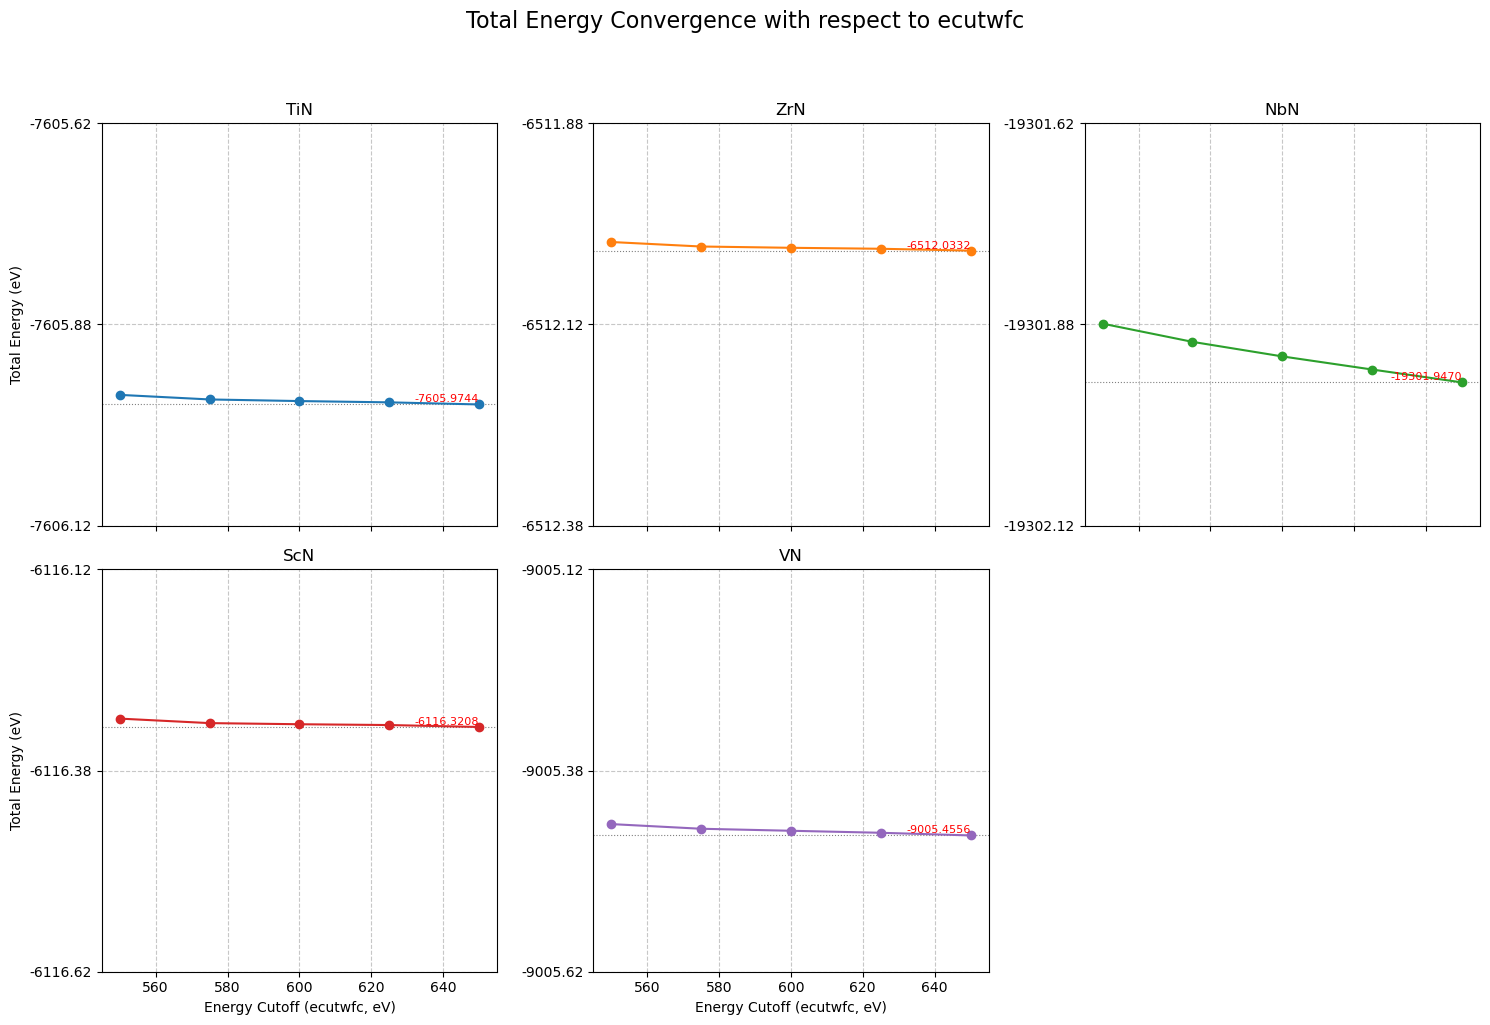

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
import csv # We now need this to read CSV files

# --- Configuration for reading the CSV file ---
input_filename = "crystal_e_convergence.csv" # Changed to CSV filename

# --- Data structures to hold parsed data ---
ecutwfc_values_ev = []
# This will store data like {crystal_name: {ecutwfc_val: energy_val, ...}}
energies_data = {}
all_crystal_names = [] # To store the order of crystals from the header

# --- Read and Parse the crystal_e_convergence.csv file ---
if not os.path.exists(input_filename):
    print(f"Error: The file '{input_filename}' was not found in the current directory.")
    print("Please make sure you have run the calculation script to generate this CSV file.")
    exit() # Exit the script if the file doesn't exist

print(f"Reading data from '{input_filename}'...")

with open(input_filename, mode='r', newline='') as csvfile:
    reader = csv.reader(csvfile)
    
    # Read header row
    header = next(reader) # Reads the first line which is the header
    
    # The first element is 'ecutwfc (eV)', the rest are crystal names
    # We need to clean the crystal names from potential leading/trailing spaces
    all_crystal_names = [name.strip() for name in header[1:]] 

    # Initialize inner dictionaries for each crystal in energies_data
    for crystal_name in all_crystal_names:
        energies_data[crystal_name] = {}

    # Parse data rows
    for row in reader:
        if not row: # Skip empty rows
            continue
        try:
            ecut = int(float(row[0])) # Convert ecutwfc from string to int
            if ecut not in ecutwfc_values_ev:
                ecutwfc_values_ev.append(ecut)
            
            for j, crystal_name in enumerate(all_crystal_names):
                # Data for crystals starts from the second column (index 1) in CSV
                energy_str = row[j + 1].strip() 
                if energy_str == "Failed" or energy_str == "N/A":
                    energies_data[crystal_name][ecut] = energy_str # Store as string
                else:
                    energies_data[crystal_name][ecut] = float(energy_str)
        except (ValueError, IndexError) as e:
            print(f"Warning: Could not parse row: '{row}' - Error: {e}")
            continue

# Ensure ecutwfc_values_ev is sorted (important for plotting order)
ecutwfc_values_ev.sort()

print("Data successfully parsed.")

### Plotting the Convergence in Subplots

# Determine the number of rows and columns for subplots
num_crystals = len(all_crystal_names)
n_cols = 3 # You can adjust this number of columns
n_rows = (num_crystals + n_cols - 1) // n_cols # Calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), sharex=True)
axes = axes.flatten() # Flatten the axes array for easy iteration

fig.suptitle('Total Energy Convergence with respect to ecutwfc', fontsize=16, y=1.02)

# Define the desired Y-axis increment
Y_AXIS_INCREMENT = .25 # eV

# Iterate through each crystal and plot on its own subplot
for i, crystal in enumerate(all_crystal_names):
    ax = axes[i] # Get the current subplot axis
    
    crystal_energies = []
    corresponding_ecuts = []

    for ecut_val in ecutwfc_values_ev:
        energy = energies_data[crystal].get(ecut_val)
        if isinstance(energy, float): # Only plot if the calculation was successful
            crystal_energies.append(energy)
            corresponding_ecuts.append(ecut_val)
    
    if crystal_energies: # Only plot if there's valid data for this crystal
        ax.plot(corresponding_ecuts, crystal_energies, marker='o', linestyle='-', label=crystal, color=f'C{i}')
        ax.set_title(f'{crystal}') # Subplot title is the crystal name
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # --- Set Y-axis ticks with a specific increment (0.5 eV) ---
        min_energy = min(crystal_energies)
        max_energy = max(crystal_energies)

        # Create a slightly larger range for the y-axis to ensure points aren't exactly on the edge
        y_lower_bound = np.floor(min_energy / Y_AXIS_INCREMENT) * Y_AXIS_INCREMENT
        y_upper_bound = np.ceil(max_energy / Y_AXIS_INCREMENT) * Y_AXIS_INCREMENT
        
        # Add a small buffer to the limits
        buffer = Y_AXIS_INCREMENT * 0.5
        ax.set_ylim(y_lower_bound - buffer, y_upper_bound + buffer)

        # Generate the tick locations based on the defined increment and new limits
        y_ticks = np.arange(y_lower_bound - buffer, y_upper_bound + buffer + Y_AXIS_INCREMENT/2, Y_AXIS_INCREMENT)
        
        ax.set_yticks(y_ticks)
        ax.set_yticklabels([f'{val:.2f}' for val in y_ticks]) # Format labels to 2 decimal places

        # Add text for the converged value (the last point)
        if len(crystal_energies) > 0:
            last_energy = crystal_energies[-1]
            last_ecut = corresponding_ecuts[-1]
            ax.text(last_ecut, last_energy, f'{last_energy:.4f}',
                    verticalalignment='bottom' if last_energy < np.mean(crystal_energies) else 'top',
                    horizontalalignment='right', fontsize=8, color='red')
            # Draw a horizontal line at the last energy for visual guidance
            ax.axhline(y=last_energy, color='gray', linestyle=':', linewidth=0.8, zorder=0) # zorder to keep line behind data

    else:
        ax.text(0.5, 0.5, 'No valid data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(f'{crystal} (No Data)')
        print(f"No valid energy data to plot for {crystal}.")

# Set common X-axis label for the bottom row of plots
for i in range(n_cols):
    # Only set x-label on the bottom row subplots that are actually used
    if (n_rows - 1) * n_cols + i < num_crystals:
        axes[(n_rows - 1) * n_cols + i].set_xlabel('Energy Cutoff (ecutwfc, eV)')

# Set common Y-axis label for the leftmost column of plots
for i in range(n_rows):
    # Only set y-label for the first subplot in each row that is actually used
    if i * n_cols < num_crystals:
        axes[i * n_cols].set_ylabel('Total Energy (eV)')


# Hide any unused subplots (if num_crystals is not a perfect multiple of n_cols)
for i in range(num_crystals, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent title overlap and labels from overlapping

# Save the plot to a file
plot_filename = "ecutwfc_convergence_subplots_plot.png"
plt.savefig(plot_filename, dpi=300) # Save as PNG with 300 DPI for good quality
print(f"\nConvergence plot saved to {plot_filename}")

# Display the plot (optional, will show a pop-up window)
plt.show()

Reading data from 'k_pnts.csv'...
Data successfully parsed.

Convergence plot saved to k_pnts_convergence_plot.png


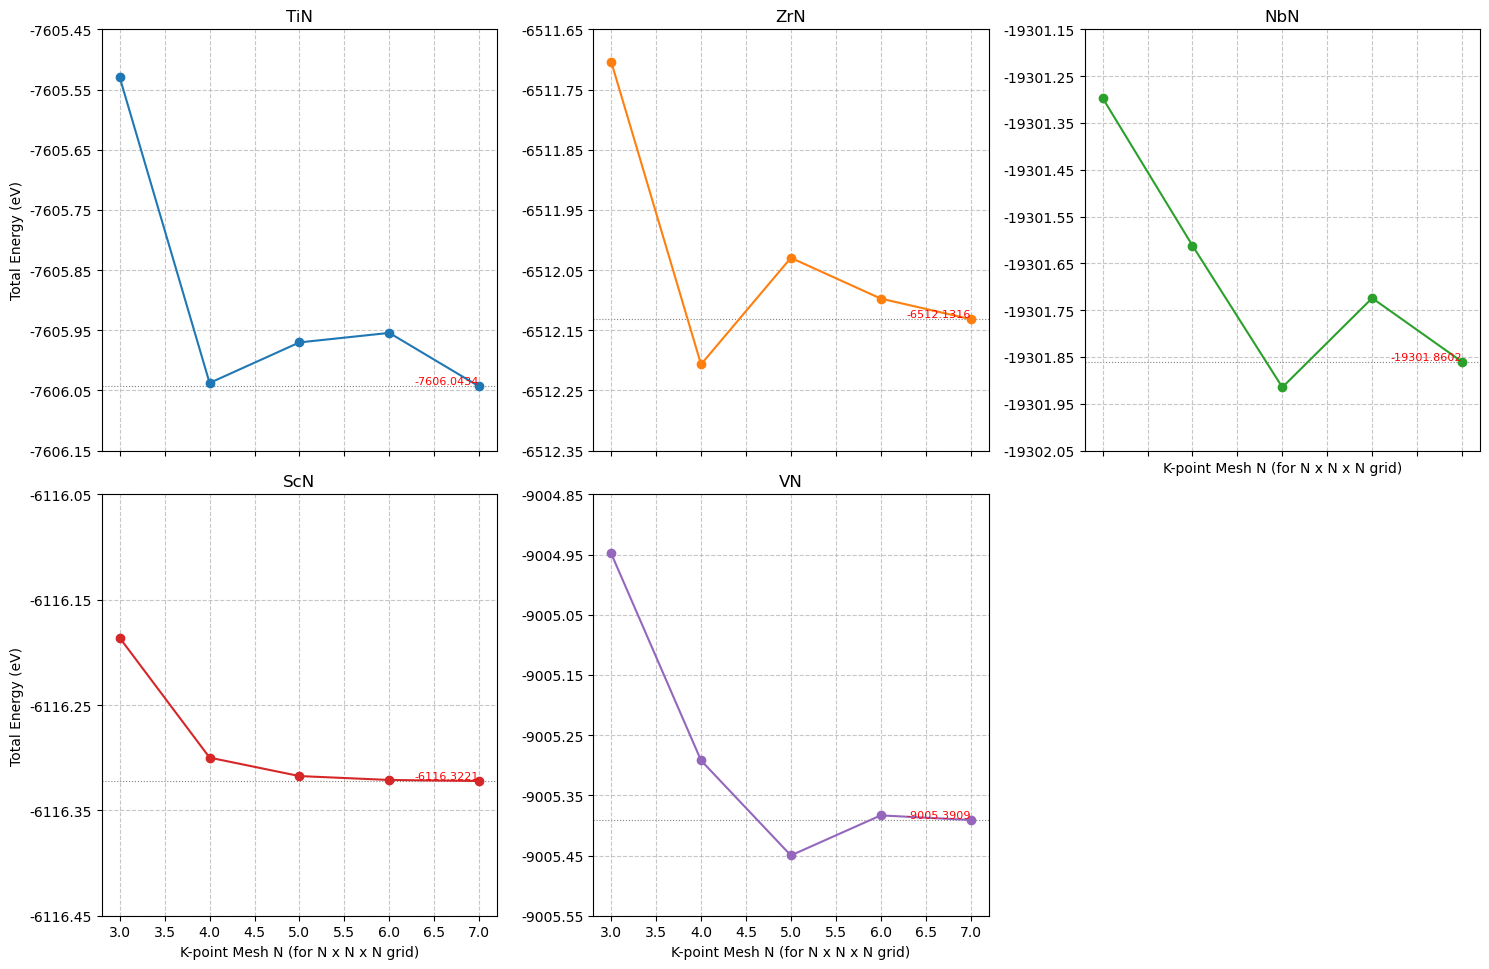

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
import csv # We need this to read CSV files

# --- Configuration for reading the CSV file ---
input_filename = "k_pnts.csv" # Changed to CSV filename

# --- Data structures to hold parsed data ---
# This will store data like {k_mesh_N_value: {crystal_name: energy, ...}}
energies_data = {}
all_crystal_names = [] # To store the order of crystals from the header
k_mesh_N_values = [] # To store the N values from (N,N,N) k-point meshes

# --- Read and Parse the k_pnts.csv file ---
if not os.path.exists(input_filename):
    print(f"Error: The file '{input_filename}' was not found in the current directory.")
    print("Please make sure you have run the k-point calculation script to generate this CSV file.")
    exit() # Exit the script if the file doesn't exist

print(f"Reading data from '{input_filename}'...")

with open(input_filename, mode='r', newline='') as csvfile:
    reader = csv.reader(csvfile)
    
    # Read header row
    header = next(reader) # Reads the first line which is the header
    
    # The first element is 'k_points', the rest are crystal names
    all_crystal_names = [name.strip() for name in header[1:]] 

    # Parse data rows
    for row in reader:
        if not row: # Skip empty rows
            continue
        try:
            # The first column is a string like "(3, 3, 3)". We need to extract '3'.
            kpt_str = row[0].strip()
            # Assuming kpt_str is always like "(N, N, N)", we can parse N
            # Extract the number inside the parentheses
            n_value = int(kpt_str.strip('()').split(',')[0].strip()) 
            
            if n_value not in k_mesh_N_values:
                k_mesh_N_values.append(n_value)
            
            # Initialize inner dictionary for this k-point N value if not already done
            if n_value not in energies_data:
                energies_data[n_value] = {}

            for j, crystal_name in enumerate(all_crystal_names):
                # Data for crystals starts from the second column (index 1) in CSV
                energy_str = row[j + 1].strip() 
                if energy_str == "Failed" or energy_str == "N/A":
                    energies_data[n_value][crystal_name] = energy_str # Store as string
                else:
                    energies_data[n_value][crystal_name] = float(energy_str)
        except (ValueError, IndexError) as e:
            print(f"Warning: Could not parse row: '{row}' - Error: {e}")
            continue

# Ensure k_mesh_N_values is sorted (important for plotting order)
k_mesh_N_values.sort()

print("Data successfully parsed.")

# --- Plotting the Convergence in Subplots ---

num_crystals = len(all_crystal_names)
n_cols = 3 # You can adjust this number of columns
n_rows = (num_crystals + n_cols - 1) // n_cols # Calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), sharex=True)
axes = axes.flatten() # Flatten the axes array for easy iteration

#fig.suptitle(f'Total Energy Convergence with respect to K-point Mesh (Ecut = {fixed_ecutwfc_ev} eV)', fontsize=16, y=1.02)

# Define the desired Y-axis increment
Y_AXIS_INCREMENT = 0.1 # eV (Adjust as needed for k-point convergence)

# Iterate through each crystal and plot on its own subplot
for i, crystal in enumerate(all_crystal_names):
    ax = axes[i] # Get the current subplot axis
    
    crystal_energies = []
    corresponding_k_mesh_Ns = []

    for n_val in k_mesh_N_values:
        energy = energies_data[n_val].get(crystal)
        if isinstance(energy, float): # Only plot if the calculation was successful
            crystal_energies.append(energy)
            corresponding_k_mesh_Ns.append(n_val)
    
    if crystal_energies: # Only plot if there's valid data for this crystal
        ax.plot(corresponding_k_mesh_Ns, crystal_energies, marker='o', linestyle='-', label=crystal, color=f'C{i}')
        ax.set_title(f'{crystal}') # Subplot title is the crystal name
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # --- Set Y-axis ticks with a specific increment (0.1 eV) ---
        min_energy = min(crystal_energies)
        max_energy = max(crystal_energies)

        # Create a slightly larger range for the y-axis to ensure points aren't exactly on the edge
        y_lower_bound = np.floor(min_energy / Y_AXIS_INCREMENT) * Y_AXIS_INCREMENT
        y_upper_bound = np.ceil(max_energy / Y_AXIS_INCREMENT) * Y_AXIS_INCREMENT
        
        # Add a small buffer to the limits
        buffer = Y_AXIS_INCREMENT * 0.5
        ax.set_ylim(y_lower_bound - buffer, y_upper_bound + buffer)

        # Generate the tick locations
        y_ticks = np.arange(y_lower_bound - buffer, y_upper_bound + buffer + Y_AXIS_INCREMENT/2, Y_AXIS_INCREMENT)
        
        ax.set_yticks(y_ticks)
        ax.set_yticklabels([f'{val:.2f}' for val in y_ticks]) # Format labels to 2 decimal places

        # Add text for the converged value (the last point)
        if len(crystal_energies) > 0:
            last_energy = crystal_energies[-1]
            last_k_mesh_N = corresponding_k_mesh_Ns[-1]
            ax.text(last_k_mesh_N, last_energy, f'{last_energy:.4f}',
                    verticalalignment='bottom' if last_energy < np.mean(crystal_energies) else 'top',
                    horizontalalignment='right', fontsize=8, color='red')
            # Draw a horizontal line at the last energy for visual guidance
            ax.axhline(y=last_energy, color='gray', linestyle=':', linewidth=0.8, zorder=0) # zorder to keep line behind data

    else:
        ax.text(0.5, 0.5, 'No valid data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(f'{crystal} (No Data)')
        print(f"No valid energy data to plot for {crystal}.")

# Set common X-axis label for the bottom row of plots
for i in range(n_cols):
    if (n_rows - 1) * n_cols + i < num_crystals: # Only set x-label on active subplots in the bottom row
        axes[(n_rows - 1) * n_cols + i].set_xlabel('K-point Mesh N (for N x N x N grid)')
    else: # If there's only one row, set on all relevant subplots
        axes[i].set_xlabel('K-point Mesh N (for N x N x N grid)')


# Set common Y-axis label for the leftmost column of plots
for i in range(n_rows):
    if i * n_cols < num_crystals: # Only set y-label on active subplots in the first column
        axes[i * n_cols].set_ylabel('Total Energy (eV)')


# Hide any unused subplots (if num_crystals is not a perfect multiple of n_cols)
for i in range(num_crystals, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent title overlap and labels from overlapping

# Save the plot to a file
plot_filename = "k_pnts_convergence_plot.png"
plt.savefig(plot_filename, dpi=300) # Save as PNG with 300 DPI for good quality
print(f"\nConvergence plot saved to {plot_filename}")

# Display the plot (optional, will show a pop-up window)
plt.show()

Reading data from 'lattice_constant_scan_results.csv'...
Data successfully parsed.

Raw lattice constant scan plot saved to lattice_constant_scan_raw_plot.png


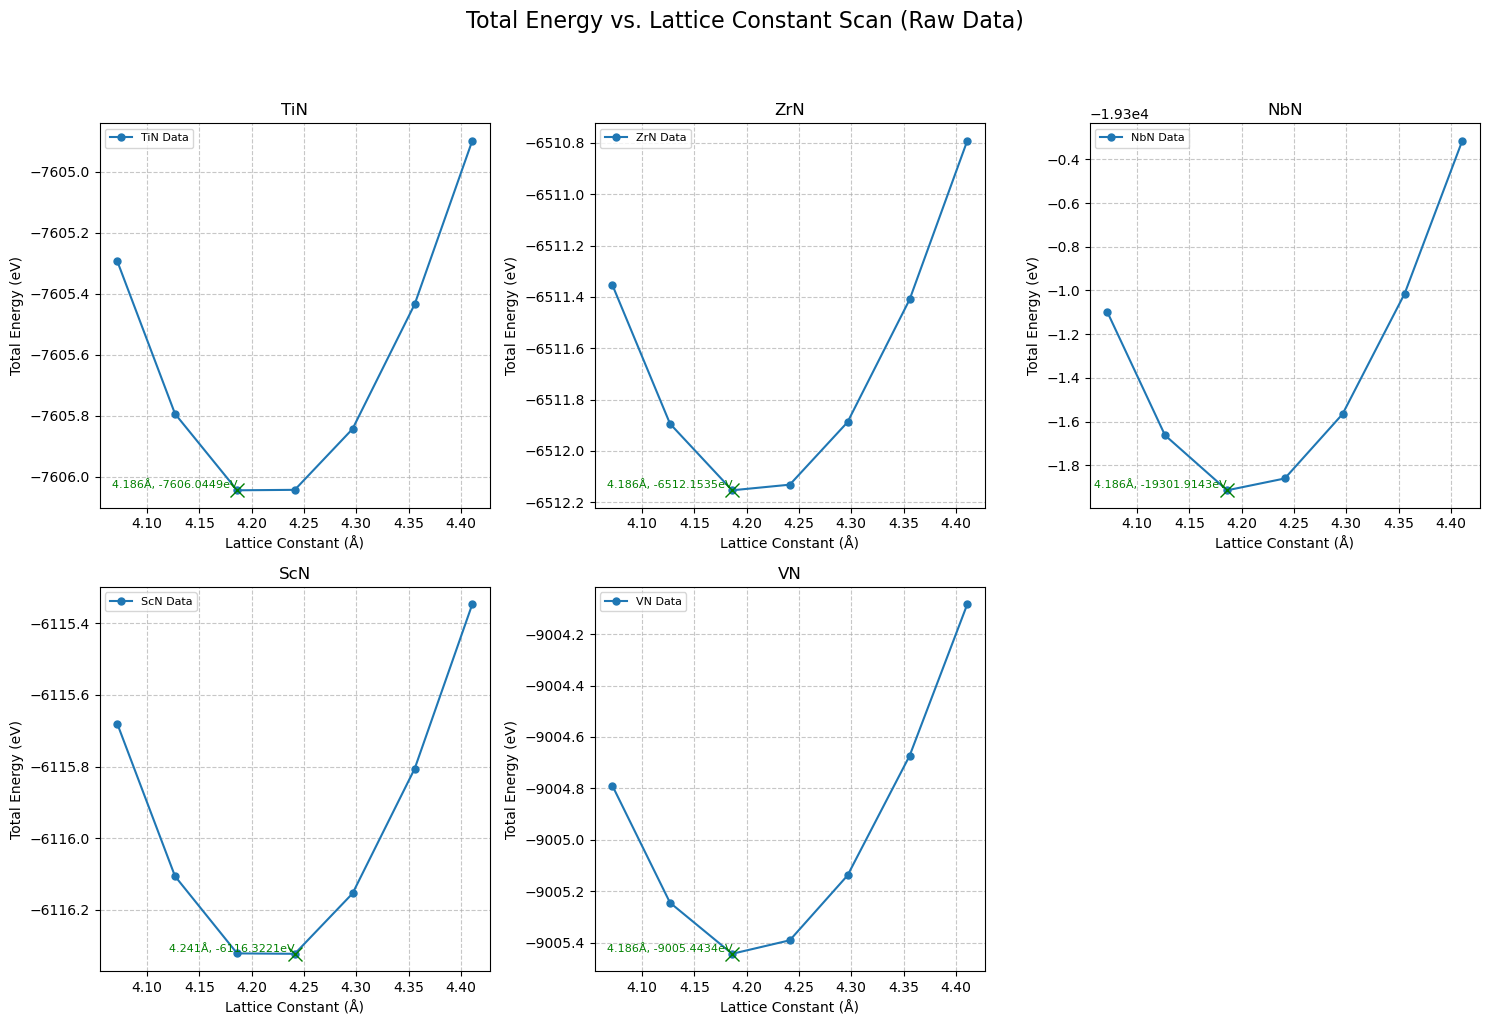

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
import csv

# --- Configuration for reading the CSV file ---
input_filename = "lattice_constant_scan_results.csv" # Updated CSV filename

# --- Data structures to hold parsed data ---
# Structure: {crystal_name: {'lattice_constants': [a1, a2, ...], 'energies': [E1, E2, ...]}}
crystal_data = {}
all_crystal_names = [] # To store crystal names in order

# --- Read and Parse the CSV file ---
if not os.path.exists(input_filename):
    print(f"Error: The file '{input_filename}' was not found in the current directory.")
    print("Please make sure you have run the lattice constant scan calculation script to generate this CSV file.")
    exit()

print(f"Reading data from '{input_filename}'...")

with open(input_filename, mode='r', newline='') as csvfile:
    reader = csv.reader(csvfile)
    
    header = next(reader) # Read the header row

    # Parse header to identify crystal names and their respective energy columns
    # The first column is 'Lattice Constant (Å)'
    # Subsequent columns are 'Crystal_Energy (eV)'
    for i, col_name in enumerate(header):
        if col_name == 'Lattice Constant (Å)':
            pass # This is our X-axis column
        elif '_Energy (eV)' in col_name:
            crystal_name = col_name.split('_Energy (eV)')[0].strip()
            all_crystal_names.append(crystal_name)
            crystal_data[crystal_name] = {'lattice_constants': [], 'energies': []}

    # Parse data rows
    for row in reader:
        if not row: # Skip empty rows
            continue
        try:
            # Extract the actual lattice constant from the first column for this row
            current_lattice_constant = float(row[0].strip())
            
            # Iterate through identified crystal names to extract their energy data
            for crystal_name in all_crystal_names:
                energy_col_idx = header.index(f'{crystal_name}_Energy (eV)')
                energy_str = row[energy_col_idx].strip()

                if energy_str != "Failed" and energy_str != "N/A":
                    crystal_data[crystal_name]['lattice_constants'].append(current_lattice_constant)
                    crystal_data[crystal_name]['energies'].append(float(energy_str))
                # Else: Skip failed/N/A entries for plotting
        except (ValueError, IndexError) as e:
            print(f"Warning: Could not parse row: '{row}' - Error: {e}")
            continue

print("Data successfully parsed.")

# --- Plotting the Lattice Constant Scan in Subplots ---

num_crystals = len(all_crystal_names)
n_cols = 3 
n_rows = (num_crystals + n_cols - 1) // n_cols 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), sharex=False, sharey=False)
axes = axes.flatten() 

fig.suptitle('Total Energy vs. Lattice Constant Scan (Raw Data)', fontsize=16, y=1.02)

# Iterate through each crystal and plot on its own subplot
for i, crystal in enumerate(all_crystal_names):
    ax = axes[i]
    
    lattice_constants = np.array(crystal_data[crystal]['lattice_constants'])
    energies = np.array(crystal_data[crystal]['energies'])
    
    if len(lattice_constants) > 0 and len(energies) > 0:
        # Plot raw data points
        ax.plot(lattice_constants, energies, 'o-', markersize=5, label=f'{crystal} Data')
        
        ax.set_title(f'{crystal}')
        ax.set_xlabel('Lattice Constant (Å)')
        ax.set_ylabel('Total Energy (eV)')
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(fontsize=8)
        
        # Optional: Add an annotation for the minimum point if data is clean
        if len(energies) > 0:
            min_energy_idx = np.argmin(energies)
            min_a = lattice_constants[min_energy_idx]
            min_E = energies[min_energy_idx]
            ax.plot(min_a, min_E, 'gx', markersize=10, label=f'Min Point: {min_a:.3f}Å')
            ax.text(min_a, min_E, f'{min_a:.3f}Å, {min_E:.4f}eV', 
                    verticalalignment='bottom' if min_E < np.mean(energies) else 'top',
                    horizontalalignment='right', fontsize=8, color='green')


    else:
        ax.text(0.5, 0.5, 'No valid data for plotting', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(f'{crystal} (No Data)')
        print(f"No valid energy data to plot for {crystal}.")

# Hide any unused subplots
for i in range(num_crystals, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.98]) 
plot_filename = "lattice_constant_scan_raw_plot.png"
plt.savefig(plot_filename, dpi=300)
print(f"\nRaw lattice constant scan plot saved to {plot_filename}")

plt.show()

In [10]:
from ase.io import read, write
from ase.visualize import view

atoms=read('TiN_ase_opt.traj', index=':')  # Read the last frame from the trajectory file
view(atoms)

<Popen: returncode: None args: ['c:\\Users\\ameer\\miniforge3\\envs\\ase\\py...>